In [277]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt
import albumentations as A
import numpy as np
import keras
import glob
import cv2
import os

In [293]:
class DataGenerator(keras.utils.Sequence):

    
    def __init__(self, augmentations='', visualize=False, batch_size=5, dim=(250,250), 
                 dim_pad=(256,256), X_n_channels=17, shuffle=True, y_n_channels=1, train=True,
                 
                 X_train_dir='C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Unet-Data/X_train/',
                 y_train_dir='C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Unet-Data/Y_train/',
                 
                 X_test_dir='C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Unet-Data/X_test/',
                 y_test_dir='C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Unet-Data/Y_test/',
                
                ):
        
        # this is the dim before padding
        
        self.dim = dim
        self.dim_pad = dim_pad
        self.visualize = visualize
        self.batch_size = batch_size
        self.X_n_channels = X_n_channels
        self.y_n_channels = y_n_channels
        self.shuffle = shuffle
        self.train = train
        
        if self.train:
            self.X_dir = X_train_dir
            self.y_dir = y_train_dir
            self.list_IDs = self.read_in_list_of_ids(X_train_dir)
        
        else:
            self.X_dir = X_test_dir
            self.y_dir = y_test_dir
            self.list_IDs = self.read_in_list_of_ids(X_test_dir)
        
        self.augment = augmentations
        self.on_epoch_end()

        
    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    
    def __getitem__(self, index):
        '''Generate one batch of data'''
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    
    def on_epoch_end(self):
        '''Updates indexes after each epoch'''
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X_no_pad = np.empty((self.batch_size, *self.dim, self.X_n_channels))
        y_no_pad = np.empty((self.batch_size, *self.dim, self.y_n_channels))
        
        X = np.empty((self.batch_size, *self.dim_pad, self.X_n_channels))
        y = np.empty((self.batch_size, *self.dim_pad, self.y_n_channels))
        

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            # Store sample
            temp_x = np.load(self.X_dir + 'X_' + ID)

            # convert from int16 -32,768 to 32,767 -> uint16 0 to 65,535
            if self.visualize:
                # min max good for vizuals but scales each image from its on min and max values.
                # as our values are reflectnce values these number mattter globaly.
                temp_x = np.where(temp_x==-9999, -99, temp_x)
                #X_no_pad[i,] = cv2.normalize(temp_x, None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)
                X_no_pad[i,] = self.normalize_image(temp_x)
            
            else:
                X_no_pad[i,] = self.convert_int16_to_uint_16(temp_x)
                
                
            # Store class
            temp_y = np.load(self.y_dir + 'Y_' + ID)

            # replace missing values with a height of 0 
            y_no_pad[i,] = np.where(temp_y==-32767.0, 0, temp_y) 
        
            if self.augment:

                augmented = self.augment(image=X_no_pad[i,], mask=y_no_pad[i,])
                X_no_pad[i,] = augmented['image']
                y_no_pad[i,] = augmented['mask']
        
        
            # regardless of augmetation or visualization 
            # padding image from 250x250x3 -> 256x256x3
            
            X[i,] = self.zero_pad_img_250_256(X_no_pad[i,])
            y[i,] = self.zero_pad_img_250_256(y_no_pad[i,])
            
            
        return X, y
    
    
    @staticmethod
    def read_in_list_of_ids(directory):
        '''
        the format of image names is as follows for both X and Y X/Y_TileId_X1_X2_Y1_Y2.npy
        create a list from either directory as follows _TileId_X1_X2_Y1_Y2.npy
        so that we can shuffle and select image pairs in the image generator.
        '''
        list_of_ids = []

        for filepath in glob.glob(directory + '*.npy'):
            filename = filepath.split('\\')[1]
            parsed_filename = '_'.join(filename.split('_')[1:])
            list_of_ids.append(parsed_filename)

        return list_of_ids
    
    
    @staticmethod
    def convert_int16_to_uint_16(img_int16):
        '''
        convert an image from int16 range -32768, 32767
        to the uint range of 0, 65535 as this is required for
        the albumentations library to work. 
        '''

        int16 = np.arange(-32768, 32767)
        uint16 = np.arange(0, 65535)
        int16_to_uint16 = dict(zip(int16, uint16))

        img_uint16 = np.vectorize(int16_to_uint16.get)(img_int16)

        return img_uint16
    
    
    @staticmethod
    def zero_pad_img_250_256(img, before_after_axis=((3, 3), (3, 3), (0, 0))):
        '''
        zero pad numpy array default will pad 250x250x3 -> 256x256x3
        each tuple in tuple refers to an axis ((3,3),(3,3),(0,0))
        so if we wanted to convert a 250x250x250x3 -> 256x256x256x3
        we would write ((3,3),(3,3),(3,3),(0,0))
        '''
        
        padded_img = np.pad(img, before_after_axis, 
                            mode='constant', constant_values=0)
        return padded_img
    
    
    @staticmethod
    def normalize_image(img, scaler=MinMaxScaler()):
        '''
        normalize image pixels between 0-1 for visualization purposes
        sklearn saclers image 250x250 is interpreted as 250 columns so 
        each column will be normalized indivdually leaving a gridline effect.
        Thats why we have to reshape our data.

        ignores last column as this is the binary settlement map.

        see https://stackoverflow.com/questions/37751717/why-does-minmaxscaler-add-lines-to-image
        '''

        channels = img.shape[-1]
        settlement_map = img[:,:,-1]
        
        as_columns = img.reshape(-1, channels)
        normalized_as_cols = scaler.fit_transform(as_columns)
        transformed_img = normalized_as_cols.reshape(img.shape)
        transformed_img[:,:,-1] = settlement_map

        return transformed_img




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


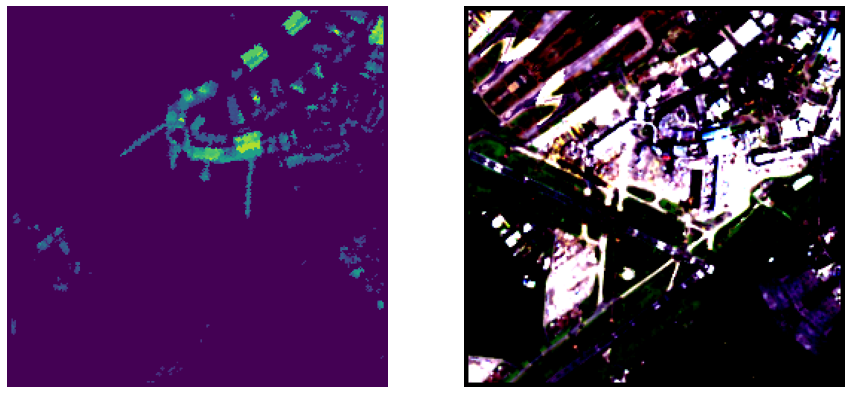

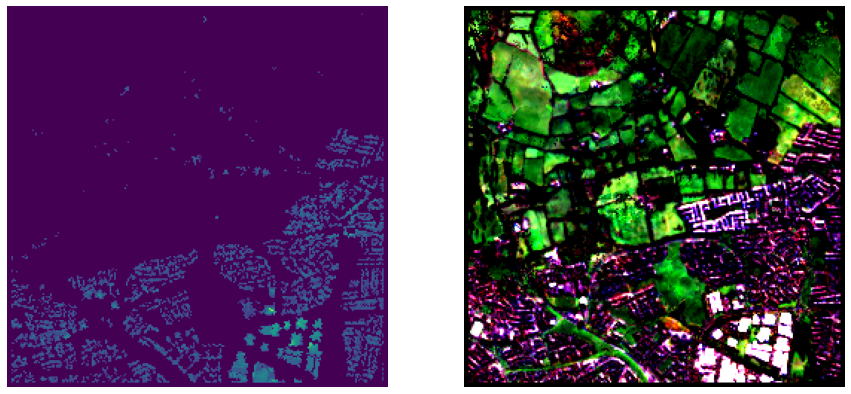

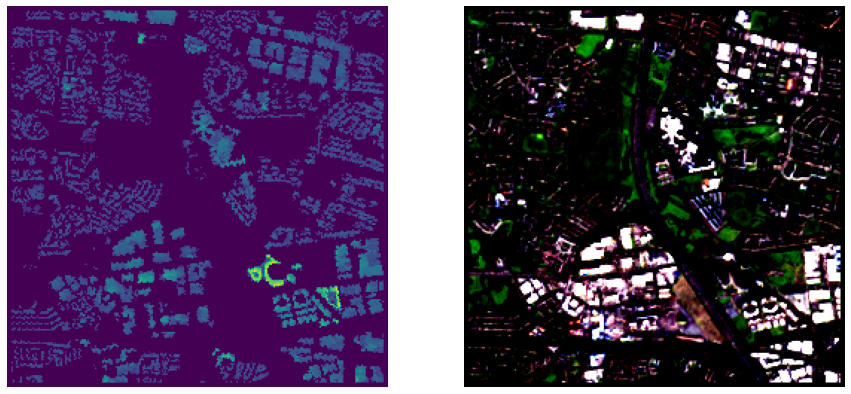

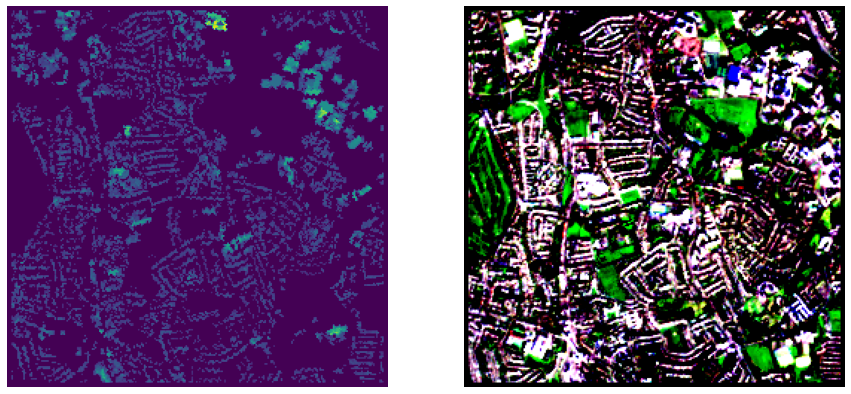

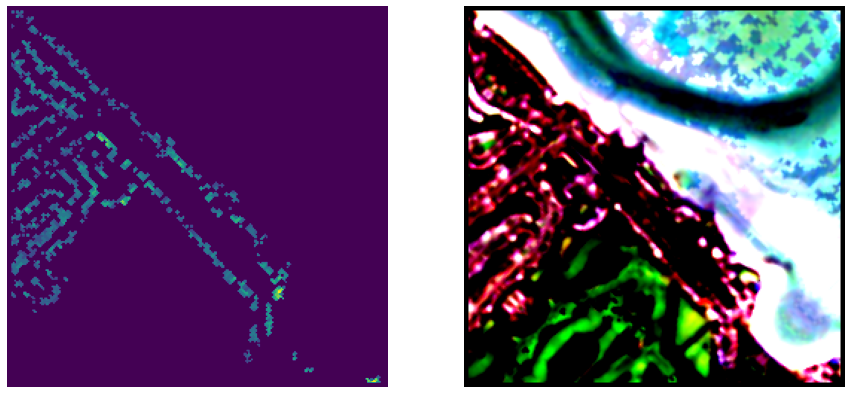

In [294]:
def create_rgb_scene(image, r=10, g=2, b=0):
    
    # convert from bgr to rgb
    width = image.shape[0]
    height = image.shape[1]
    channel = 3
    
    img_rgb = np.empty((*(width,height), channel))
    img_rgb[:,:,0] = image[:,:,r]
    img_rgb[:,:,1] = image[:,:,g]
    img_rgb[:,:,2] = image[:,:,b]
    
    return img_rgb
    
    
def visulaize(augments='', train=True):
    
    data = DataGenerator(augmentations=augments, visualize=True, train=train).__getitem__(1)
    
    for i in range(len(data[0])):
        
        X = data[0][i]
        y = data[1][i]

        rgb_image = create_rgb_scene(X)

        height_image = y

        fig = plt.figure(figsize=(15, 15))
        ax1 = fig.add_subplot(1,2,1)
        ax1.axis('off')
        ax1.imshow(height_image)

        ax2 = fig.add_subplot(1,2,2)
        ax2.axis('off')
        ax2.imshow(rgb_image)
    

augmentations_train = A.Compose([
    
    # need to convert uint (0,65535) -> float (0-1)
    #A.ToFloat(max_value=65535.0),
    A.ToFloat(1),
    
    # spatial transforms
    A.RandomResizedCrop(width=250, height=250, p=0.2),
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
    A.RandomRotate90(p=0.25),
    A.ShiftScaleRotate(p=0.25),
    
    # pixel distortions
    A.RandomBrightnessContrast(p=0.2),
    A.RandomBrightness(p=0.2),
    A.RandomGamma(p=0.2),
    
    ])


augmentations_test = A.Compose([
    
    # need to convert uint (0,65535) -> float (0-1)
    A.ToFloat(max_value=65535.0),
    
    ])
    
    
visulaize(augmentations_train, train=True)

# Unet-Model

In [211]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    '''
    Down Covolutional block of unet
    '''
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding,
                            strides=strides, activation="relu")(x)
    
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding,
                            strides=strides, activation="relu")(c)
    
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    
    return c, p



def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    '''
    Up Covolutional block of unet
    '''
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding,
                            strides=strides, activation="relu")(concat)
    
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding,
                            strides=strides, activation="relu")(c)
    
    return c


def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    '''
    the bottle neck in unet that joins down convolutional and up convolutional
    blocks.
    '''
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding,
                            strides=strides, activation="relu")(x)
    
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding,
                            strides=strides, activation="relu")(c)
    
    return c



def UNet():
    '''
    defining the unet model architecture
    '''
    
    layer_nodes = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, layer_nodes[0]) #128 -> 64
    c2, p2 = down_block(p1, layer_nodes[1]) #64 -> 32
    c3, p3 = down_block(p2, layer_nodes[2]) #32 -> 16
    c4, p4 = down_block(p3, layer_nodes[3]) #16->8
    
    bn = bottleneck(p4, layer_nodes[4])
    
    u1 = up_block(bn, c4, layer_nodes[3]) #8 -> 16
    u2 = up_block(u1, c3, layer_nodes[2]) #16 -> 32
    u3 = up_block(u2, c2, layer_nodes[1]) #32 -> 64
    u4 = up_block(u3, c1, layer_nodes[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="relu")(u4)
    model = keras.models.Model(inputs, outputs)
    
    return model

In [212]:
image_size = 256

training_generator = DataGenerator(augmentations=augmentations_train, train=True, visualize=False)
testing_generator  = DataGenerator(augmentations=augmentations_test,  train=False, visualize=False)

unet_model = UNet()
unet_model.compile(optimizer='adam', loss='mean_squared_logarithmic_error', metrics=['mse'])
unet_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_193 (Conv2D)             (None, 256, 256, 16) 448         input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, 256, 256, 16) 2320        conv2d_193[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_52 (MaxPooling2D) (None, 128, 128, 16) 0           conv2d_194[0][0]                 
____________________________________________________________________________________________

In [213]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

unet_model.fit_generator(
                training_generator,
                epochs=3000,
                validation_data=testing_generator,
                workers=2, use_multiprocessing=False,
                callbacks=[callback]
)


Epoch 1/3000
48/48 [==============================] - 119s 2s/step - loss: 0.6444 - mse: 10.5925 - val_loss: 0.5431 - val_mse: 7.0013
Epoch 2/3000
48/48 [==============================] - 112s 2s/step - loss: 0.6039 - mse: 10.1877 - val_loss: 0.5451 - val_mse: 7.2323
Epoch 3/3000
48/48 [==============================] - 114s 2s/step - loss: 0.6565 - mse: 11.5297 - val_loss: 0.5415 - val_mse: 7.0348
Epoch 4/3000
48/48 [==============================] - 104s 2s/step - loss: 0.6484 - mse: 11.1734 - val_loss: 0.5408 - val_mse: 7.0605
Epoch 5/3000
48/48 [==============================] - 107s 2s/step - loss: 0.6350 - mse: 11.2626 - val_loss: 0.5408 - val_mse: 7.1343
Epoch 6/3000
48/48 [==============================] - 108s 2s/step - loss: 0.6902 - mse: 13.0348 - val_loss: 0.5405 - val_mse: 7.0874
Epoch 7/3000
48/48 [==============================] - 106s 2s/step - loss: 0.6312 - mse: 11.3067 - val_loss: 0.5405 - val_mse: 7.1000
Epoch 8/3000
48/48 [==============================] - 108s 2s/

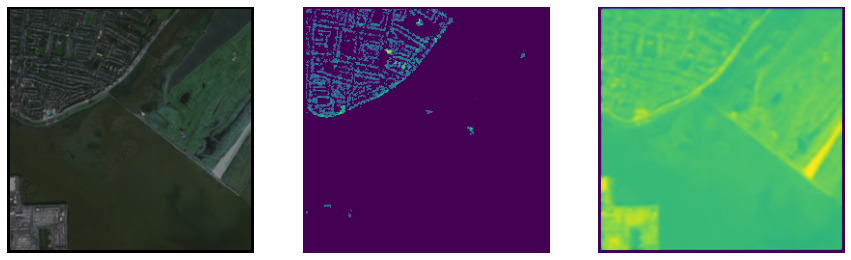

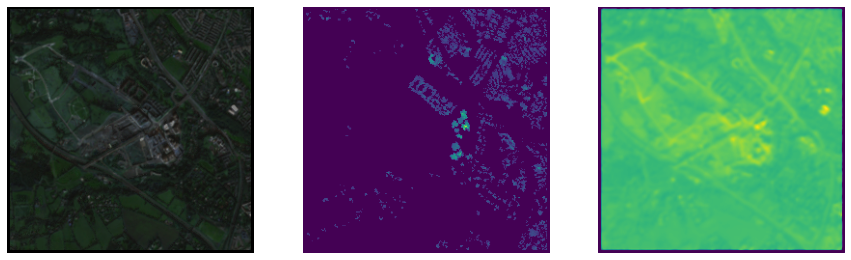

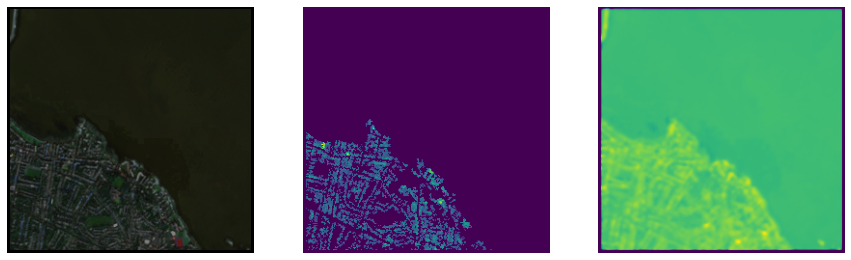

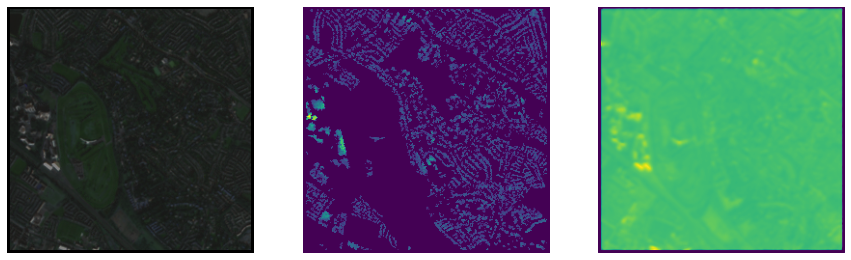

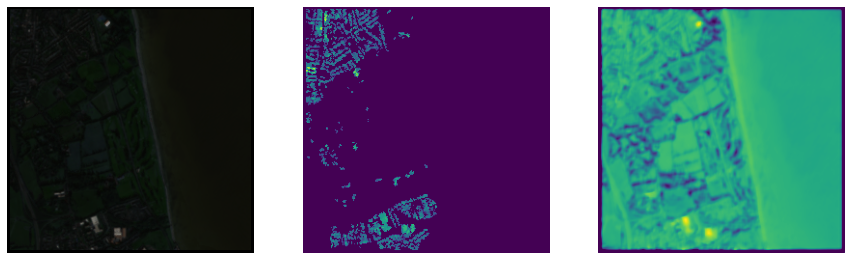

In [215]:
def visulaize_predictions(model, augments=''):
    
    data  = DataGenerator(augmentations=augments, train=False, visualize=True).__getitem__(1)
    preds = model.predict(data[0])
    
    for i in range(len(data[0])):
    
        X = data[0][i]
        y = data[1][i]
        
        pred = preds[i]
        rgb_image = create_rgb_scene(X)
        height_image = y

        fig = plt.figure(figsize=(15, 15))
        
        ax1 = fig.add_subplot(1,3,1)
        ax1.axis('off')
        ax1.imshow(rgb_image)
        
        ax2 = fig.add_subplot(1,3,2)
        ax2.axis('off')
        ax2.imshow(height_image)

        ax3 = fig.add_subplot(1,3,3)
        ax3.axis('off')
        ax3.imshow(pred)
        
        
visulaize_predictions(model=unet_model,#
                      augments=augmentations_test)

In [ ]:
unet_model.save_weights('rgb_model_weights.hdf5')